In [29]:
import pandas as pd
import fitdecode
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import datetime

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

In [18]:
file_path = 'C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/athletes_activities/athlete5/6618041716.fit'

In [19]:
# Caminho da pasta que terá iteração nos seus arquivos
folder_path = 'C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/athletes_activities/athlete5'

In [20]:
''' Script pra achar algum arquivo corrompido '''

'''
# Contador de linhas para servir de index
count = 0

# Itera por cada arquivo na pasta
for filename in os.listdir(folder_path):
    # Junta o nome do arquivo com o caminho da pasta
    full_path = os.path.join(folder_path, filename)    

    try:

        # Lê o arquivo no formato específico com a biblioteca gpxo
        with fitdecode.FitReader(full_path) as fit_file:
            for frame in fit_file: 
                continue

    except:

        # Printa o index e o nome do arquivo que ocorreu algum erro na leitura
        print(count, f"An error ocurred on {filename}")
    
    # Acréscimo no contador para reiniciar o loop
    count +=1

'''

'\n# Contador de linhas para servir de index\ncount = 0\n\n# Itera por cada arquivo na pasta\nfor filename in os.listdir(folder_path):\n    # Junta o nome do arquivo com o caminho da pasta\n    full_path = os.path.join(folder_path, filename)    \n\n    try:\n\n        # Lê o arquivo no formato específico com a biblioteca gpxo\n        with fitdecode.FitReader(full_path) as fit_file:\n            for frame in fit_file: \n                continue\n\n    except:\n\n        # Printa o index e o nome do arquivo que ocorreu algum erro na leitura\n        print(count, f"An error ocurred on {filename}")\n    \n    # Acréscimo no contador para reiniciar o loop\n    count +=1\n\n'

In [21]:
df_athlete_dict = {
    'activity_date': [],
    'total_distance (km)': [], 
    'total_time (min)': [],
    'pace (min/km)': [],
    'velocity (km/h)': []    
}

# Itera por cada arquivo na pasta
for filename in os.listdir(folder_path):
    # Junta o nome do arquivo com o caminho da pasta
    full_path = os.path.join(folder_path, filename)

    with fitdecode.FitReader(full_path) as fit_file:
        for frame in fit_file:
            if frame.frame_type == fitdecode.FIT_FRAME_DATA:
                if frame.name == 'session':
                    for field in frame.fields:
                        if field.name == 'start_time':
                            df_athlete_dict['activity_date'].append(field.value)

                        elif field.name == 'total_distance':
                            total_dist_km = field.value / 1000
                            df_athlete_dict['total_distance (km)'].append(round((total_dist_km),2))

                        elif field.name == 'total_timer_time':
                            total_time_min = field.value // 60
                            df_athlete_dict['total_time (min)'].append(total_time_min)
    
    if total_dist_km == 0:
        df_athlete_dict['pace (min/km)'].append(0)
    else:    
        df_athlete_dict['pace (min/km)'].append(round((total_time_min / total_dist_km),2))

    df_athlete_dict['velocity (km/h)'].append(round(total_dist_km / (total_time_min / 60),2))

In [22]:
# Passando o dicionário com as features criadas para um Dataframe
df_athlete_activities = pd.DataFrame(df_athlete_dict)

In [23]:
# Convertendo a coluna de data para o fuso horário local e arrendado em dias
df_athlete_activities['activity_date'] = df_athlete_activities['activity_date'].dt.tz_convert('America/Sao_Paulo').dt.tz_localize(None).dt.round('d')

In [24]:
# Removendo datas duplicadas relacionadas à 2 ou mais atividades no mesmo dia
df_athlete_activities.drop_duplicates(subset='activity_date', inplace= True)

In [25]:
# Atribuindo tipo de atividade para 'Atividade'
df_athlete_activities.insert(2, 'activity_type', 'Atividade')

In [26]:
# Ordenando a data da menor pra maior e resetando index
df_athlete_activities.sort_values('activity_date', ascending=True, inplace=True)
df_athlete_activities.reset_index(drop=True, inplace= True)

In [30]:
# Fazendo a diferença entre a atividade seguinte e a anterior e preenchendo a primeira linha com 0
df_athlete_activities['days_between_activities'] = df_athlete_activities['activity_date'].diff(periods=1).fillna(datetime.timedelta(days=1))

# Alterando o tipo da coluna para int
df_athlete_activities['days_between_activities'] = (df_athlete_activities['days_between_activities'].dt.days) - 1

In [31]:
# Data da primeira atividade
start = df_athlete_activities['activity_date'].iloc[0]

# Data da última atividade
end = df_athlete_activities['activity_date'].iloc[-1]

# Dias entre a primeira e última atividade
dates = pd.date_range(start,end,freq='d')

# Colocando todas as datas em um df
df_dates = pd.DataFrame({'activity_date': dates})
df_dates

,activity_date
0,2021-11-08
1,2021-11-09
2,2021-11-10
3,2021-11-11
4,2021-11-12
...,...
955,2024-06-20
956,2024-06-21
957,2024-06-22
958,2024-06-23


In [32]:
# Right join pra poder manter os dados das atividades existentes mas adicionar linhas para os novos dias
df_athlete_activities = df_dates.merge(df_athlete_activities, on='activity_date', how='left')

# Preechendo os valores nulos como Dia sem atividade
df_athlete_activities['activity_type'].fillna('Dia sem atividade', inplace=True)

In [33]:
# Preenchendo os valores NaN com 1 para poder fazer uma subtração cumulativa
df_athlete_activities['days_between_activities'].fillna(-1, inplace= True)

# Fazendo cumsum com valores negativos e depois multiplicando por -1 pra transformá-los em positivos
df_athlete_activities['days_between_activities'] = df_athlete_activities['days_between_activities'].cumsum() * -1

# Transformando em int pra evitar -0 ao invés de 0
df_athlete_activities['days_between_activities'] = df_athlete_activities['days_between_activities'].astype(int)

In [34]:
df_athlete_activities

,activity_date,total_distance (km),activity_type,total_time (min),pace (min/km),velocity (km/h),days_between_activities
0,2021-11-08,7.02,Atividade,39.0,5.56,10.79,0
1,2021-11-09,NaN,Dia sem atividade,NaN,NaN,NaN,1
2,2021-11-10,NaN,Dia sem atividade,NaN,NaN,NaN,2
3,2021-11-11,NaN,Dia sem atividade,NaN,NaN,NaN,3
4,2021-11-12,6.72,Atividade,45.0,6.70,8.96,0
...,...,...,...,...,...,...,...
955,2024-06-20,0.00,Atividade,48.0,0.00,0.00,0
956,2024-06-21,0.00,Atividade,26.0,0.00,0.00,0
957,2024-06-22,NaN,Dia sem atividade,NaN,NaN,NaN,1
958,2024-06-23,14.91,Atividade,90.0,6.04,9.94,0


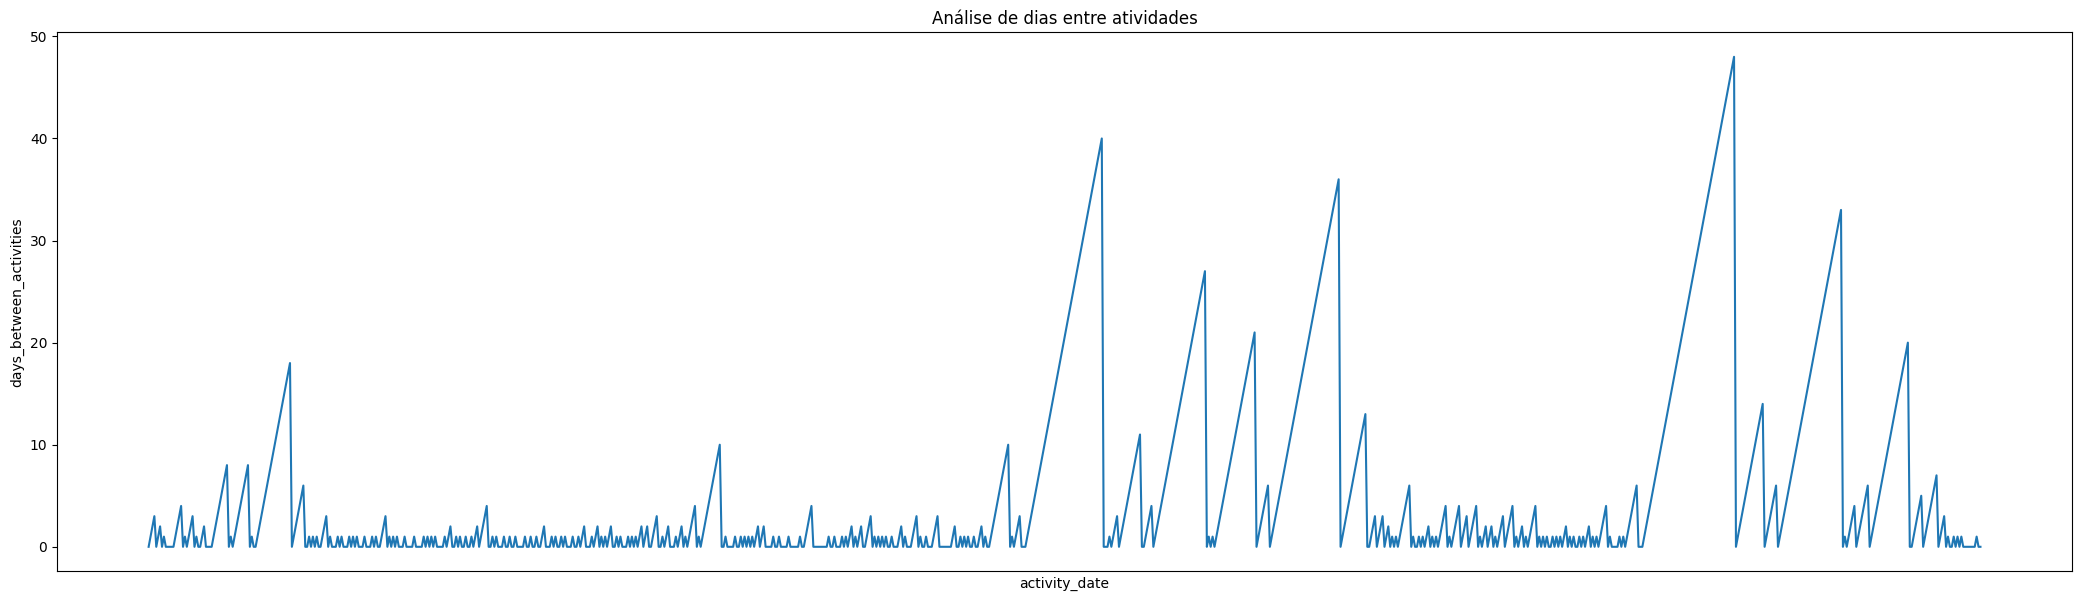

In [35]:
fig, ax = plt.subplots(figsize =(26, 7))
sns.lineplot(x = 'activity_date', y= 'days_between_activities', data= df_athlete_activities)
plt.xticks([])
plt.title('Análise de dias entre atividades')
plt.show()

In [36]:
'''
frame_names = set()

with fitdecode.FitReader(file_path) as fit_file:
    for frame in fit_file:
        if frame.frame_type == fitdecode.FIT_FRAME_DATA:
            frame_names.add(frame.name)

frame_names
'''

{'activity',
 'device_info',
 'device_settings',
 'event',
 'file_creator',
 'file_id',
 'lap',
 'record',
 'session',
 'sport',
 'unknown_113',
 'unknown_13',
 'unknown_140',
 'unknown_141',
 'unknown_147',
 'unknown_216',
 'unknown_22',
 'unknown_233',
 'unknown_79',
 'user_profile',
 'zones_target'}

In [37]:
'''
sports = set()

for filename in os.listdir(folder_path):
    # Junta o nome do arquivo com o caminho da pasta
    full_path = os.path.join(folder_path, filename)


    with fitdecode.FitReader(full_path) as fit_file:
        for frame in fit_file:
            if frame.frame_type == fitdecode.FIT_FRAME_DATA:
                if frame.name == 'session':
                    for field in frame.fields: 
                        if field.name == 'sport':
                            #print(f"Frame name: {frame.name}, Field Name: {field.name}, Field Value: {field.value}")
                            sports.add(field.value)
sports          
'''                
                

{54, 'cycling', 'running', 'swimming', 'training', 'walking'}